# R Demo: Tiled GEDI dataset on the MAAP

## 1. Database layout and simple access

This notebook demonstrates the capabilities of the tiled GEDI dataset: a (moderately) filtered copy of the GEDI data that is spatiotemporally sorted into tiles covering 1º x 1º x 1 year.

We will be working with a demo version of the database hosted at: 
`s3://maap-ops-workspace/shared/ameliah/gedi-test/brazil_tiles/data`

This database was constructed to the following specification:
- All GEDI footprints from 2019 - 2023 (first phase of the GEDI mission)
- Version 2.1
- Products L2A, L2B, L4A, and L4C, joined on shot_number
- Footprints are pre-filtered for:
    - Level 2A quality_flag == 1 (** n.b. this is not the same as the L4A flag "l2a_quality_flag")
    - 0.9 <= sensitivity_a0 <= 1
    - 0.95 < sensitivity_a2 <= 1
    - degrade_flag %in% [0, 3, 8, 10, 13, 18, 20, 23, 28, 30, 33, 38, 40, 43, 48, 60, 63, 68]
    - surface_flag == 1
- If a footprint is not present in all four products, it will not be present in the database.

The demo database covers Brazil and is divided into 818 1ºx1º tiles as shown below:

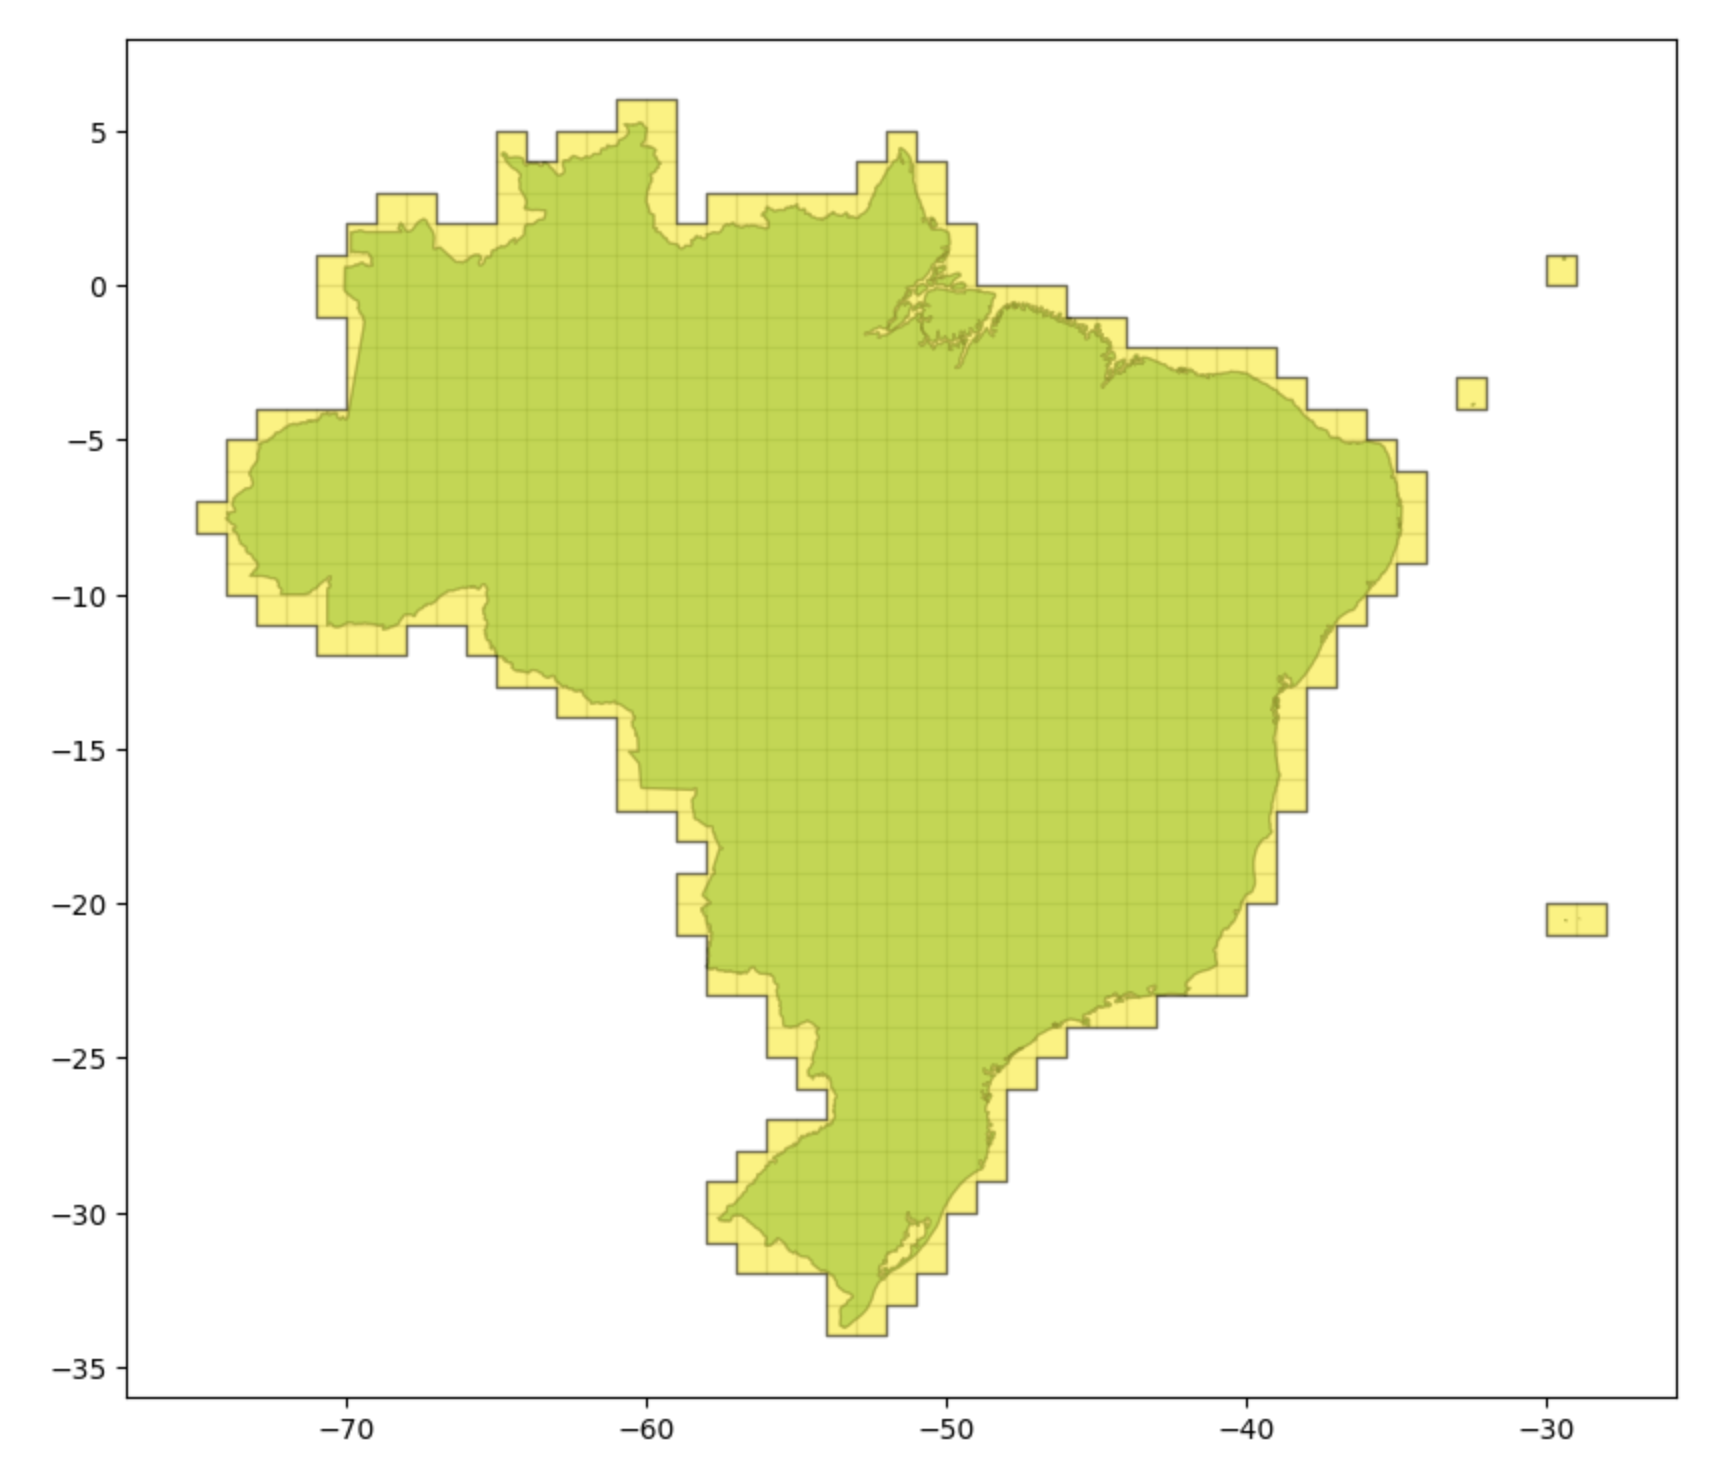

Tiles are named in the format `[NS][##]_[EW][###]`, specifying the top left corner of the tile.

Thus, S21_W049 covers latitudes in the range [-21, -22) and longitudes in the range [-49, -48).


### Start by setting up your environment

In an R MAAP workspace with at least 16GB of memory, run

`$ conda env update -f /projects/shared-buckets/ameliah/repos/r_duckdb_env.yml`

(If installing from scratch, you will need the packages `r-duckdb, r-duckplyr, r-devtools, r-pkgload=1.4.1 `)

Then load the following libraries at the top of your R script:

In [4]:
# Load packages
library("duckdb")
library("duckplyr")
library("sf")

# Load helper functions
# TODO(Amelia): this is a bizarre choice and should be done with devtools
download.file("https://raw.githubusercontent.com/ameliaholcomb/gedi_tiler/refs/heads/main/gtiler/database/ducky.R", destfile = "ducky.R")
source("ducky.R")
file.remove("ducky.R")

Loading required package: DBI



Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


The duckplyr package is configured to fall back to dplyr when it encounters an
incompatibility. Fallback events can be collected and uploaded for analysis to
guide future development. By default, data will be collected but no data will
be uploaded.
ℹ Automatic fallback uploading is not controlled and therefore disabled, see
  `?duckplyr::fallback()`.
✔ Number of reports ready for upload: 23.
→ Review with `duckplyr::fallback_review()`, upload with
  `duckplyr::fallback_upload()`.
ℹ Configure automatic uploading with `duckplyr::fallback_config()`.

✔ Overwriting dplyr methods with duckplyr methods.
ℹ Turn off with `duckplyr::methods_restore()`.


Attaching package: ‘duckplyr’


The following object is masked from ‘package:duckdb’:

    read_csv_duckdb


Lin

[1] TRUE

### TL;DR: I just want to read one tile

In [5]:
# Set up GEDI data table
gedi <- get_gedi_demo_table()

In [46]:
tile <- "S21_W049" # your tile_id goes here
tdf <- gedi |>
    filter(tile_id == tile) |>
    select(-geometry) |>
    collect()

# tdf is a data frame with all the GEDI shots for this tile
print("NRows, NCols")
print(dim(tdf))
head(tdf, 10)

[1] "NRows, NCols"
[1] 1099476     281


shot_number,elev_lowestmode,delta_time,sensitivity,sensitivity_a1,sensitivity_a2,degrade_flag,quality_flag,landsat_treecover,modis_treecover,⋯,wsci_xy,wsci_xy_pi_lower,wsci_xy_pi_upper,wsci_z,wsci_z_pi_lower,wsci_z_pi_upper,granule,absolute_time,tile_id,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dttm>,<chr>,<dbl>
4.843e+16,546.6480,56840613,0.9196497,0.9196497,0.9642888,0,1,0,7,⋯,5.239630,3.874005,6.605256,3.987978,2.527488,5.448467,O04843_04,2019-10-20 21:03:32,S21_W049,2019
4.843e+16,552.8438,56840613,0.9193029,0.9193029,0.9677212,0,1,0,7,⋯,4.448482,2.460503,6.436460,3.855117,2.394627,5.315606,O04843_04,2019-10-20 21:03:32,S21_W049,2019
4.843e+16,557.9420,56840613,0.9307649,0.9307649,0.9723060,0,1,0,5,⋯,4.491585,2.503606,6.479563,3.846448,2.385959,5.306938,O04843_04,2019-10-20 21:03:32,S21_W049,2019
4.843e+16,558.8804,56840613,0.9113170,0.9113170,0.9638699,0,1,0,5,⋯,4.627255,2.639277,6.615233,3.929951,2.469462,5.390441,O04843_04,2019-10-20 21:03:32,S21_W049,2019
4.843e+16,557.1823,56840613,0.9171697,0.9171697,0.9689386,0,1,0,5,⋯,4.723762,2.735783,6.711740,3.928780,2.468290,5.389269,O04843_04,2019-10-20 21:03:32,S21_W049,2019
4.843e+16,557.8428,56840613,0.9435021,0.9435021,0.9788133,0,1,0,5,⋯,4.554320,2.566342,6.542299,3.824970,2.364480,5.285460,O04843_04,2019-10-20 21:03:32,S21_W049,2019
4.843e+16,557.1065,56840613,0.9265028,0.9265028,0.9700567,0,1,0,5,⋯,4.450440,2.462462,6.438419,3.849425,2.388935,5.309914,O04843_04,2019-10-20 21:03:32,S21_W049,2019
4.843e+16,555.5040,56840613,0.9530959,0.9530959,0.9831145,0,1,0,5,⋯,4.908318,2.920340,6.896297,3.934041,2.473551,5.394530,O04843_04,2019-10-20 21:03:32,S21_W049,2019
4.843e+16,553.3867,56840613,0.9295867,0.9295867,0.9698229,0,1,0,5,⋯,4.979435,2.991457,6.967414,3.914580,2.454091,5.375070,O04843_04,2019-10-20 21:03:32,S21_W049,2019


#### Cool! Tell me more ...
The above code made use of a framework called DuckDB, along with a small helper library (`ducky.R`). 
While you can sidestep this framework and read the individual per-tile data files directly out of S3 with R dataframes/pandas/geopandas if you are so inclined, these tools are not designed with large datasets in mind and will be relatively slow.

The Tiled GEDI dataset is laid out in a format such that many distributed frameworks will be able to help you quickly scan and query the data. These tools, which include DuckDB, Spark, Dask, and others, are designed to help you run your usual dataframe code over datasets that are too large to fit in memory. You can use these tools alone or in combination with R dataframes/geopandas -- for example, selecting a subset of the data from the database with a fast query framework and then converting it to your standard library for further processing.

Below is an introduction to using [DuckDB](https://duckdb.org) to work with the GEDI data.


I suggest restarting your Jupyter notebook Kernel at this point to clean up the memory used by the tile loaded in Part 1, then you are ready to run the cell below:

### Use a duckDB table as a backing dataframe for dplyr

DuckDB is a query engine that supports efficient querying of large datasets split among many files.
In this case, we are going to use DuckDB as the backing framework for dplyr. This will give us (most of) the usual dplyr table functionality. However, unlike a usual table that is fully read out of a single file and loaded into memory, this one is "lazily loaded". That means that rows and columns are only computed/read from disk when requested.

We can see this at the bottom of the print: an unknown number of rows remain after the first select.

In [6]:
tile <- "S21_W049"
# select, filter
gedi |>
    select(shot_number, agbd, rh_98, l4_quality_flag) |>
    filter(l4_quality_flag == 1 & agbd > 0)

# Source:   SQL [?? x 4]
# Database: DuckDB 1.4.1 [root@Linux 5.4.0-1021-aws-fips:R 4.4.3/:memory:]
   shot_number  agbd rh_98 l4_quality_flag
         <dbl> <dbl> <dbl>           <int>
 1     4.36e16  121.  17.5               1
 2     4.36e16  152.  22.7               1
 3     4.36e16  230.  28.7               1
 4     4.36e16  143.  28.9               1
 5     4.36e16  163.  26.3               1
 6     4.36e16  160.  27.5               1
 7     4.36e16  409.  24.6               1
 8     4.36e16  177.  27.4               1
 9     4.36e16  123.  22.9               1
10     4.36e16  155.  24.4               1
# ℹ more rows

In [7]:
# computed values
gedi |>
    filter (l4_quality_flag == 1 & tile_id == tile) |>
    summarise(mean_biomass = mean(agbd), mean_rh98 = mean(rh_98), n = n()) 

Warning message:
“Missing values are always removed in SQL aggregation functions.
Use `na.rm = TRUE` to silence this warning
This warning is displayed once every 8 hours.”


# Source:   SQL [?? x 3]
# Database: DuckDB 1.4.1 [root@Linux 5.4.0-1021-aws-fips:R 4.4.3/:memory:]
  mean_biomass mean_rh98      n
         <dbl>     <dbl>  <dbl>
1         12.2      5.29 598656

#### Spatial querying

In [10]:
# I can't figure out how to pass another geospatial dataframe into duckplyr st_contains() with R
# For now, assuming your shape is just one row, I think the easiest thing to do is pass it as a WKT
# Let me know if you want to work with multirow geometries
region <- sf::st_read("/projects/shared-buckets/ameliah/shapefiles/test_region.shp")
region_wkt <- sf::st_as_text(region$geom)
region_crs <- glue::glue("EPSG:{sf::st_crs(region$geom)$epsg}")
print(region_crs)
print(region_wkt)

Reading layer `test_region' from data source 
  `/projects/shared-buckets/ameliah/shapefiles/test_region.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -63.2 ymin: -4.2 xmax: -62.8 ymax: -3.8
Geodetic CRS:  WGS 84
EPSG:4326
[1] "POLYGON ((-62.8 -4.2, -63.2 -4.2, -63.2 -3.8, -62.8 -3.8, -62.8 -4.2))"


In [17]:
# Fast spatial queries: Use get_covering_tiles() to find tiles intersecting your region
# and use these as a filter on tile_id before doing the more expensive st_contains() operation
# This will keep the runtime constant even as the database grows.

covering_tiles <- get_covering_tiles(region) # from ducky.R

gedi |>
    filter(tile_id %in% covering_tiles) |>
    filter(l4_quality_flag == 1) |>
    # if your region is not EPSG:4326, transform the GEDI geometry to match as follows:
    # filter(st_contains(region_wkt, st_transform(geometry, 'EPSG:4326', region_crs))) |>
    filter(st_contains(region_wkt, geometry)) |>
    summarise(mean_agbd = mean(agbd), mean_rh98 = mean(rh_98), n = n())

# Source:   SQL [?? x 3]
# Database: DuckDB 1.4.1 [root@Linux 5.4.0-1021-aws-fips:R 4.4.3/:memory:]
  mean_agbd mean_rh98     n
      <dbl>     <dbl> <dbl>
1      126.      20.8 53236

### Other dplyr functions: date columns, group by

Duckplyr has (most -- but not all!) of the same functionality as dplyr, but using duckDB as a backend.

For example, the tiled GEDI dataset includes the column `absolute_time`, which is a datetime timestamp.
We can use the standard R library `lubridate` to interact with this data type.

In [23]:
library("lubridate")
gedi |>
    filter(tile_id %in% covering_tiles) |>
    filter(l4_quality_flag == 1) |>
    filter(st_contains(region_wkt, geometry)) |>
    select(shot_number, absolute_time) |>
    mutate(
        month = month(absolute_time),
        add_day = date_add(absolute_time, days(1))
    )


# Source:   SQL [?? x 4]
# Database: DuckDB 1.4.1 [root@Linux 5.4.0-1021-aws-fips:R 4.4.3/:memory:]
   shot_number absolute_time       month add_day            
         <dbl> <dttm>              <dbl> <dttm>             
 1     3.46e16 2019-07-23 19:52:11     7 2019-07-24 19:52:11
 2     3.46e16 2019-07-23 19:52:11     7 2019-07-24 19:52:11
 3     3.46e16 2019-07-23 19:52:11     7 2019-07-24 19:52:11
 4     3.46e16 2019-07-23 19:52:11     7 2019-07-24 19:52:11
 5     3.46e16 2019-07-23 19:52:11     7 2019-07-24 19:52:11
 6     3.46e16 2019-07-23 19:52:11     7 2019-07-24 19:52:11
 7     3.46e16 2019-07-23 19:52:11     7 2019-07-24 19:52:11
 8     3.46e16 2019-07-23 19:52:11     7 2019-07-24 19:52:11
 9     3.46e16 2019-07-23 19:52:11     7 2019-07-24 19:52:11
10     3.46e16 2019-07-23 19:52:11     7 2019-07-24 19:52:11
# ℹ more rows

Another common use case is groupby. Here, your code should have one small adjustment: 

instead of the R `groupby()`, use `.by = ...` in `summarise`.
(groupby often works, but it can have unexpected behavior.)

For example, say we were running an analysis on phenology with GEDI,
and we wanted to understand how biomass and PAI varied from month to month in our region.

We want to know per-month mean biomass and pai in our region,
as well as a summary of what GEDI data went into the monthly averages:
- how many footprints fell in each month
- a list of the years in which we got data for each month

In [24]:
gedi |>
    filter(tile_id %in% covering_tiles) |>
    filter(l4_quality_flag == 1) |>
    filter(st_contains(region_wkt, geometry)) |>
    select(shot_number, absolute_time, agbd, pai) |>
    mutate(
        month = month(absolute_time),
        year = year(absolute_time),
    ) |>
    summarise(
        mean_agbd = mean(agbd),
        mean_pai = mean(pai),
        n = n(),
        years = paste0(list(distinct(year))),
        .by = month
    ) |>
    arrange(month)


# Source:     SQL [?? x 5]
# Database:   DuckDB 1.4.1 [root@Linux 5.4.0-1021-aws-fips:R 4.4.3/:memory:]
# Ordered by: month
   month mean_agbd mean_pai     n years                   
   <dbl>     <dbl>    <dbl> <dbl> <chr>                   
 1     1      91.2     2.41  5427 [2020, 2021, 2022]      
 2     2      86.2     2.39  1123 [2023, 2021]            
 3     3     182.      3.62    23 [2022]                  
 4     4     132.      2.99 17144 [2020, 2021, 2022]      
 5     5      96.9     2.57  2829 [2022, 2019]            
 6     6     119.      3.07  2260 [2019, 2021, 2020]      
 7     7     126.      2.82  5238 [2021, 2019, 2022]      
 8     8     121.      2.85  4328 [2022, 2021, 2019]      
 9     9     113.      2.75  3935 [2022, 2019, 2021]      
10    10     142.      3.28  7155 [2020, 2019, 2022, 2021]
11    12     167.      3.68  3774 [2022]                  

### Converting back to R dataframes
When converting from a DuckDB table to an R dataframe, make sure the table is small enough to fit in memory!

DuckDB is designed to execute queries on larger-than-memory datasets. The Brazil demo database, for example, contains 176 GB of data. If you read this large dataset into an R dataframe, it will cause R to crash. 

Instead, use select(), filter(), and/or summarise() to get a small-ish dataset (~1 million rows or fewer). You can check the number of rows with `count()` or `summarise(n = n())` to be sure.

Then, you can convert to an R dataframe with a simple `select` + `collect`:

In [18]:
rdf <- gedi |>
    filter(l4_quality_flag == 1 & agbd > 0 & tile_id == "S21_W049") |>
    select(shot_number, agbd, pai_z_0, pai_z_1, dz, lat_lowestmode, lon_lowestmode) |>
    collect()
head(rdf, 5)

shot_number,agbd,pai_z_0,pai_z_1,dz,lat_lowestmode,lon_lowestmode
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4.843e+16,2.299228,0.05615720,0,5,-21.28894,-48.99738
4.843e+16,2.750601,0.11990180,0,5,-21.30137,-48.98665
4.843e+16,3.430358,0.03100931,0,5,-21.32062,-48.96998
4.843e+16,1.870119,0.07298426,0,5,-21.32821,-48.96340
4.843e+16,2.750601,0.01650933,0,5,-21.34825,-48.94602


## ⚠️ Important notes on SPATIAL columns in duckplyr ⚠️

`collect` will throw an error if used on a dataframe with a geometry column. You can do the spatial operations in duckdb (as seen above with st_contains), but if you want to pull the data into R memory, I recommend dropping the geometry column `(select(-geometry))`, and using the `lat_lowestmode` and `lon_lowestmode` columns instead.

In theory, we can convert DuckDB -> spatial dataframe in R using the `duckdbfs::to_sf()` function.
However, I have found converting the geometries to be very memory-intensive and slow in R.
I think it's not worth it unless you are converting fewer than ~50 rows.


Another slightly confusing thing is that duckplyr does not display the geometry column on a duckdb table, so you also have to use `lon_lowestmode` and `lat_lowestmode` if you want to preview the longitude and latitude.

In [ ]:
# It looks like the geometry column is invalid
gedi |>
    filter (l4_quality_flag == 1 & agbd > 0 & tile_id == "S21_W049") |>
    select (shot_number, agbd, lon_lowestmode, lat_lowestmode, geometry)


# Source:   SQL [?? x 5]
# Database: DuckDB 1.4.0 [unknown@Linux 5.4.0-1021-aws-fips:R 4.4.3/:memory:]
   shot_number  agbd lon_lowestmode lat_lowestmode geometry  
         <dbl> <dbl>          <dbl>          <dbl> <list>    
 1     4.84e16  2.30          -49.0          -21.3 <raw [32]>
 2     4.84e16  2.75          -49.0          -21.3 <raw [32]>
 3     4.84e16  3.43          -49.0          -21.3 <raw [32]>
 4     4.84e16  1.87          -49.0          -21.3 <raw [32]>
 5     4.84e16  2.75          -48.9          -21.3 <raw [32]>
 6     4.84e16  4.90          -48.9          -21.4 <raw [32]>
 7     4.84e16  4.70          -48.9          -21.4 <raw [32]>
 8     4.84e16  1.82          -48.9          -21.4 <raw [32]>
 9     4.84e16  1.82          -48.9          -21.4 <raw [32]>
10     4.84e16  1.82          -48.9          -21.4 <raw [32]>
# ℹ more rows

In [20]:
# but if we bring it into memory with to_sf(), we can see that it is correct
df <- gedi |>
    filter (l4_quality_flag == 1 & agbd > 0 & tile_id == "S21_W049") |>
    select (shot_number, agbd, lon_lowestmode, lat_lowestmode, geometry) |>
    # Use head() to make sure we read just a few rows
    head(10) |>
    to_sf()

print(df)

Simple feature collection with 10 features and 4 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -48.99738 ymin: -21.40233 xmax: -48.8991 ymax: -21.28894
CRS:           NA
   shot_number     agbd lon_lowestmode lat_lowestmode
1    4.843e+16 2.299228      -48.99738      -21.28894
2    4.843e+16 2.750601      -48.98665      -21.30137
3    4.843e+16 3.430358      -48.96998      -21.32062
4    4.843e+16 1.870119      -48.96340      -21.32821
5    4.843e+16 2.750601      -48.94602      -21.34825
6    4.843e+16 4.896555      -48.94393      -21.35066
7    4.843e+16 4.699281      -48.92309      -21.37467
8    4.843e+16 1.817380      -48.90084      -21.40032
9    4.843e+16 1.817380      -48.90049      -21.40073
10   4.843e+16 1.817380      -48.89910      -21.40233
                          geom
1  POINT (-48.99738 -21.28894)
2  POINT (-48.98665 -21.30137)
3  POINT (-48.96998 -21.32062)
4   POINT (-48.9634 -21.32821)
5  POINT (-48.94602 -21.34825)
6  POINT (-48.94393 -21.35066